In [27]:
import os
import cv2
import torch
import numpy as np
import torchsummary

from matplotlib import pyplot as plt
import segmentation_models_pytorch as smp
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [28]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [29]:
train_image_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/1.training/1.training/436219-7159-48057-[1, 0, 0].png'
valid_img_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/img/02.png'

In [30]:
train_image = cv2.resize(cv2.imread(train_image_path), (224, 224))
valid_image = cv2.resize(cv2.imread(valid_img_path), (224, 224))

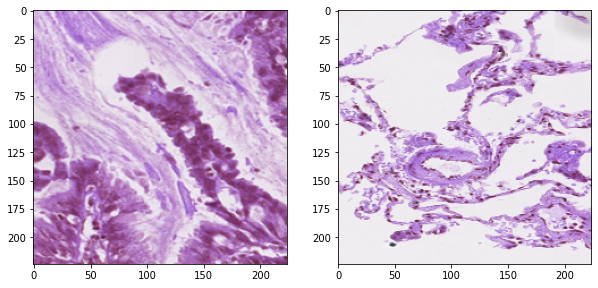

In [31]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(train_image)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(valid_image)

In [32]:
model_weights = ['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/' + x for x in os.listdir('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models') if 'deeplab' in x and '50' in x]
model_weights.sort()
model_weights

['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/deeplabv3plus_all_dJ_par_resnet50_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/deeplabv3plus_dJ_par_resnet50_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/deeplabv3plus_dice_resnet50_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/deeplabv3plus_dice_resnet50_02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/deeplabv3plus_means_dJ_par_resnet50_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/deeplabv3plus_means_dJ_par_resnet50_02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/deeplabv3plus_resnet50_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/deeplabv3plus_resnet50_02.pth']

In [33]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)

In [34]:
def calculate_slice_bboxes(
    image_height: int,
    image_width: int,
    slice_height: int = 224,
    slice_width: int = 224,
    overlap_height_ratio: float = 0.2,
    overlap_width_ratio: float = 0.2,
) -> list[list[int]]:
    """
    Given the height and width of an image, calculates how to divide the image into
    overlapping slices according to the height and width provided. These slices are returned
    as bounding boxes in xyxy format.

    :param image_height: Height of the original image.
    :param image_width: Width of the original image.
    :param slice_height: Height of each slice
    :param slice_width: Width of each slice
    :param overlap_height_ratio: Fractional overlap in height of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :param overlap_width_ratio: Fractional overlap in width of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :return: a list of bounding boxes in xyxy format
    """

    slice_bboxes = []
    y_max = y_min = 0
    y_overlap = int(overlap_height_ratio * slice_height)
    x_overlap = int(overlap_width_ratio * slice_width)
    while y_max < image_height:
        x_min = x_max = 0
        y_max = y_min + slice_height
        while x_max < image_width:
            x_max = x_min + slice_width
            if y_max > image_height or x_max > image_width:
                xmax = min(image_width, x_max)
                ymax = min(image_height, y_max)
                xmin = max(0, xmax - slice_width)
                ymin = max(0, ymax - slice_height)
                slice_bboxes.append([xmin, ymin, xmax, ymax])
            else:
                slice_bboxes.append([x_min, y_min, x_max, y_max])
            x_min = x_max - x_overlap
        y_min = y_max - y_overlap
    return slice_bboxes

In [35]:
train_image_tensor = preprocess_image(train_image, mean=[0.698, 0.535, 0.768], std=[0.134, 0.192, 0.149]) #[0.698, 0.535, 0.768], [0.134, 0.192, 0.149]
valid_image_tensor = preprocess_image(valid_image, mean=[0.698, 0.535, 0.768], std=[0.134, 0.192, 0.149])

In [36]:
model = smp.DeepLabV3Plus(encoder_name='resnet50', classes=4, activation=None, encoder_weights=None, ).to(device)

In [37]:
model.load_state_dict(torch.load(f=model_weights[5], map_location=device))

<All keys matched successfully>

In [38]:
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [39]:
train_out = model(train_image_tensor.to(device))
valid_out = model(valid_image_tensor.to(device))

In [40]:
t = torch.nn.functional.softmax(train_out, dim=1)

In [41]:
t = np.transpose(t.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
t.shape

(224, 224, 4)

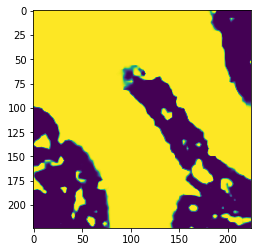

In [46]:
plt.imshow(t[:, :, 3])

In [82]:
x = t.round()

In [83]:
x.shape

(224, 224, 4)

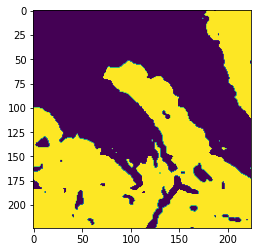

In [84]:
#plt.imshow(x.astype(np.float32))
plt.imshow(x[:, :, 0])

## Valid Image

In [47]:
t = torch.nn.functional.softmax(valid_out, dim=1)

In [48]:
t = np.transpose(t.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
t.shape

(224, 224, 4)

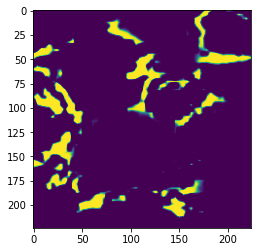

In [53]:
plt.imshow(t[:, :, 2])

In [88]:
x = t.round()

In [89]:
x.shape

(224, 224, 4)

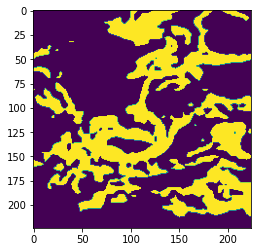

In [90]:
#plt.imshow(x.astype(np.float32))
plt.imshow(x[:, :, 2])

## Testing valid baseline img

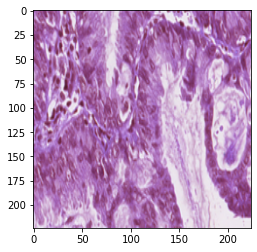

In [116]:
#valid_img_base = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/img/03.png'
valid_img_base = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/436219-7159-48987-[1, 1, 0].png'
valid_image_base = cv2.resize(cv2.imread(valid_img_base), (224, 224))
valid_base_tensor = preprocess_image(valid_image_base)
plt.imshow(valid_image_base)

Text(0.5, 1.0, 'background')

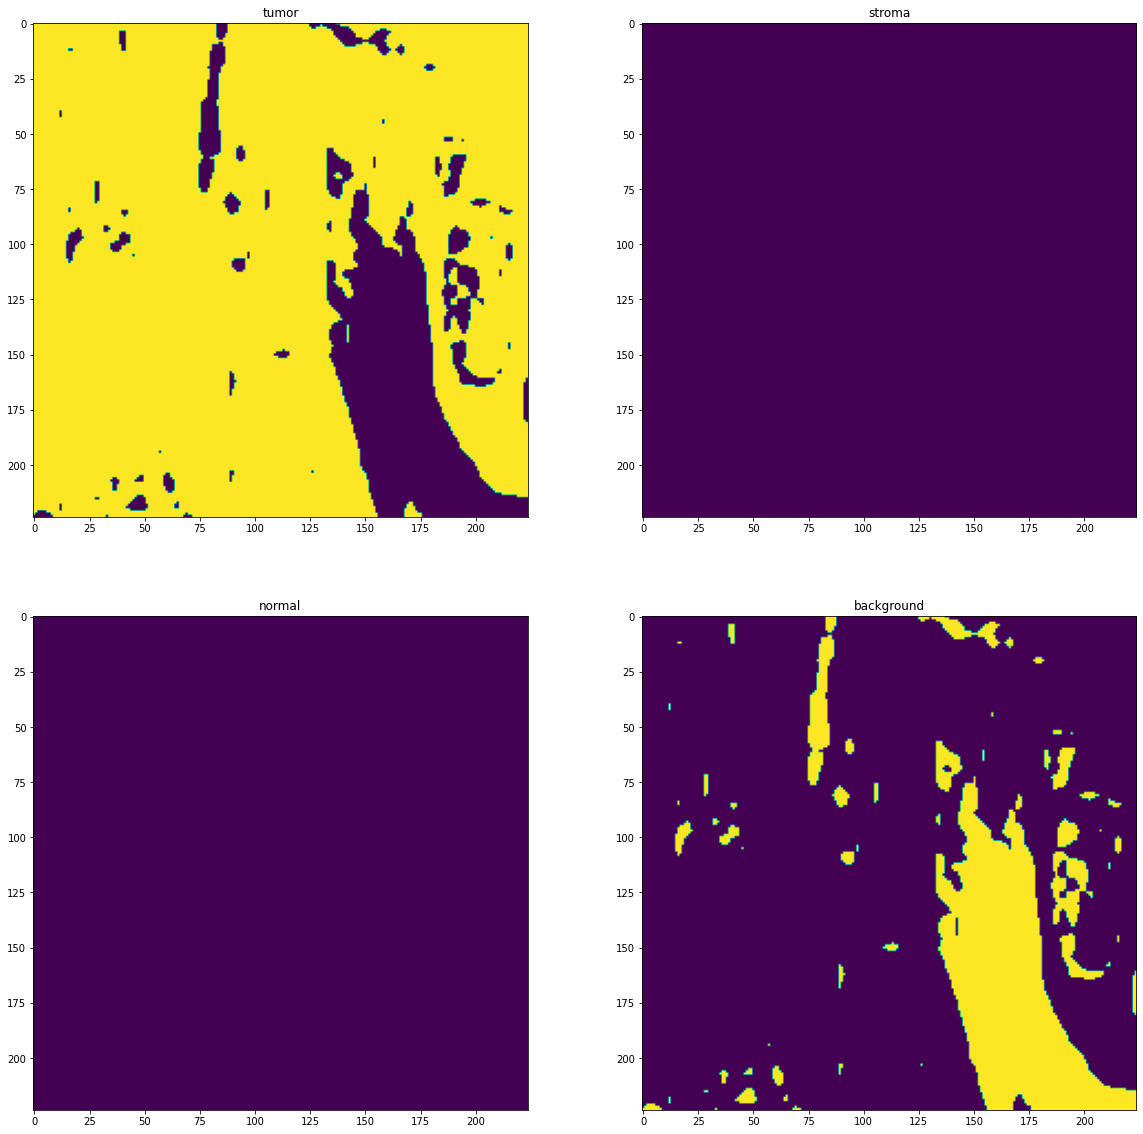

In [117]:
model_out = model(valid_base_tensor.to(device))
t = torch.nn.functional.softmax(model_out, dim=1)
t = np.transpose(t.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
t = t.round()

fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(t[:, :, 0])
plt.title('tumor')

ax = fig.add_subplot(2, 2, 2)
plt.imshow(t[:, :, 1])
plt.title('stroma')

ax = fig.add_subplot(2, 2, 3)
plt.imshow(t[:, :, 2])
plt.title('normal')

ax = fig.add_subplot(2, 2, 4)
plt.imshow(t[:, :, 3])
plt.title('background')